# Cosmic-ray Neutrons to Soil Moisture

The use of cosmic-ray neutrons for measuring rootzone soil moisture is a fairly new and non-invasive sensing technique capable of providing field average soil water content at high temporal resolution. The instrument fills a unique niche left by traditional point-level sensors and satellite missions.

In this exercise we will go over the process of converting counts of epithermal neutrons into soil moisture at hourly intervals from a CRS-1000/B (Hydroinnova, Albuquerque, NM) neutron detector. The instrument was mounted on a tripod in a small field at the Konza prairie. The tripod also contained a Campbell Scientific air temperature and relative humidity sensor (CS215) and the Hydroinnova device contained two barometers within the enclosure (there is a ventilation valve to ensure atmospheric pressure within the enclosure is the same as the atmospheric pressure.


In [129]:
# Import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [130]:
# Load cosmic-ray data
df = pd.read_csv("../datasets/stationary_cosmos_hydroinnova.csv")
df.head()


,RecordNum,Date Time(UTC),P4_mb,P1_mb,T1_C,RH1,T_CS215,RH_CS215,Vbat,N1Cts,N1ET_sec,N1T_C,N1RH
0,1,2019/12/01 00:00:00,961.45,961.4,7.2,13.3,4.7,50.9,12.802,2364,3601,10.5,0
1,2,2019/12/01 01:00:00,961.79,961.6,6.4,12.6,3.8,51.4,12.761,2282,3599,9.3,0
2,3,2019/12/01 02:00:00,961.77,961.6,4.8,12.1,2.6,57.3,12.729,2283,3600,7.7,0
3,4,2019/12/01 03:00:00,961.97,961.9,4.2,11.9,2.3,60.0,12.710,2238,3600,7.0,0
4,5,2019/12/01 04:00:00,962.73,962.6,3.9,11.8,1.8,67.9,12.692,2333,3600,6.5,0


In [131]:
# Convert timestamp into Pandas datetime object
df["Date Time(UTC)"] = pd.to_datetime(df["Date Time(UTC)"], format="%Y/%m/%d %H:%M:%S")
df.insert(2,"Date Time(CST)",df["Date Time(UTC)"] - pd.DateOffset(hours=6))
df.head()


,RecordNum,Date Time(UTC),Date Time(CST),P4_mb,P1_mb,T1_C,RH1,T_CS215,RH_CS215,Vbat,N1Cts,N1ET_sec,N1T_C,N1RH
0,1,2019-12-01 00:00:00,2019-11-30 18:00:00,961.45,961.4,7.2,13.3,4.7,50.9,12.802,2364,3601,10.5,0
1,2,2019-12-01 01:00:00,2019-11-30 19:00:00,961.79,961.6,6.4,12.6,3.8,51.4,12.761,2282,3599,9.3,0
2,3,2019-12-01 02:00:00,2019-11-30 20:00:00,961.77,961.6,4.8,12.1,2.6,57.3,12.729,2283,3600,7.7,0
3,4,2019-12-01 03:00:00,2019-11-30 21:00:00,961.97,961.9,4.2,11.9,2.3,60.0,12.710,2238,3600,7.0,0
4,5,2019-12-01 04:00:00,2019-11-30 22:00:00,962.73,962.6,3.9,11.8,1.8,67.9,12.692,2333,3600,6.5,0


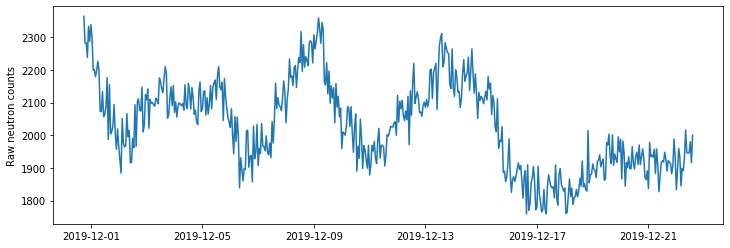

In [132]:
# Inspect data
plt.figure(figsize=(12,4))
plt.plot(df["Date Time(CST)"], df["N1Cts"]) 
plt.ylabel('Raw neutron counts')
plt.show()


In [133]:
# For simplicity, store pandas columsn into shorted variable names
T = df["T_CS215"]
RH = df["RH_CS215"]
P = (df["P1_mb"] + df["P4_mb"])/2
N_raw = df["N1Cts"]


## Compute vapor pressure

In [134]:
# Compute Saturation vapor pressure (Pws)
T = T + 273  # Celisus to Kelvin
Tc = 647.1 # Critical temperature,  K
Pc = 220640  # Critical pressure  mb
C1 = -7.86
C2 = 1.84
C3 = -11.77
C4 = 22.68
C5 = -15.96
C6 = 1.80
theta = 1 - T/Tc

# Saturation vapor pressure in mb
Pws = np.exp(Tc/T*(C1*theta + C2*theta**1.5 + C3*theta**3 + C4*theta**3.5 + C5*theta**4 + C6*theta**7.5))*Pc
Pws = Pws * 100 # mb or hPa -> Pa


## Correct raw nuetron counts

This correction mainly takes into account the effect of atmospheric pressure and water vapor

In [173]:
# Atmospheric pressure correction (all in milibars)
beta = 0.0077 # atmospheric attenuation coefficient (mb^-1) (see Dong et al. 2014 p.4)
Pref = 970 # Average atmospheric pressure in mbars 
fp = np.exp(beta*(P-Pref))# # Pressure factor (fp) [Eq. 1] Hawdon et al. 2014

# Atmospheric water vapor correction
Pw = Pws * RH/100 # Vapor pressure in Pascals
A_ref = 0 # 0 g m^-3 (dry air)
C = 2.16679 # g K/J;
A = C * Pw/(T+273.15) # Absolute humidity [g/m^3]
fwv = 1 + 0.0054*(A-A_ref)

# Incoming neutron intensity correction
fi = 1 # fi = Im/Iref;

# Apply correction factors
df["N_corrected"] = np.round(N_raw * (fp*fwv/fi))

# Inspect new variable in dataframe
df.head()


,RecordNum,Date Time(UTC),Date Time(CST),P4_mb,P1_mb,T1_C,RH1,T_CS215,RH_CS215,Vbat,N1Cts,N1ET_sec,N1T_C,N1RH,N_corrected
0,1,2019-12-01 00:00:00,2019-11-30 18:00:00,961.45,961.4,7.2,13.3,4.7,50.9,12.802,2364,3601,10.5,0,2233.0
1,2,2019-12-01 01:00:00,2019-11-30 19:00:00,961.79,961.6,6.4,12.6,3.8,51.4,12.761,2282,3599,9.3,0,2159.0
2,3,2019-12-01 02:00:00,2019-11-30 20:00:00,961.77,961.6,4.8,12.1,2.6,57.3,12.729,2283,3600,7.7,0,2161.0
3,4,2019-12-01 03:00:00,2019-11-30 21:00:00,961.97,961.9,4.2,11.9,2.3,60.0,12.710,2238,3600,7.0,0,2123.0
4,5,2019-12-01 04:00:00,2019-11-30 22:00:00,962.73,962.6,3.9,11.8,1.8,67.9,12.692,2333,3600,6.5,0,2227.0


## Covert corrected neutron counts into soil water content


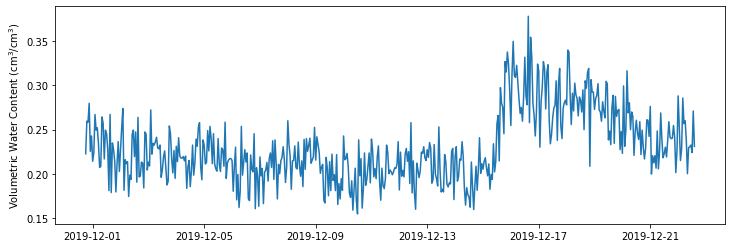

In [174]:
# Define approximate bulk density for the field
bulk_density = 1.4 # g/cm^3

# Gravimetric water content
gwc = (0.0808 / (df["N_corrected"]/3500-0.372) - 0.115 - 0.03) # Equation by Desilets

# Volumetric water content
vwc =  gwc * bulk_density/0.998 


# Plot soil moisture
plt.figure(figsize=(12,4))
plt.plot(df["Date Time(CST)"], vwc) 
plt.ylabel('Volumetric Water Content (cm$^3$/cm$^3$)')
plt.show()


## References

Franz, T.E., Zreda, M., Ferre, T.P.A., Rosolem, R., Zweck, C., Stillman, S., Zeng, X. and Shuttleworth, W.J., 2012. Measurement depth of the cosmic ray soil moisture probe affected by hydrogen from various sources. Water Resources Research, 48(8).

Hawdon, A., McJannet, D. and Wallace, J., 2014. Calibration and correction procedures for cosmic‐ray neutron soil moisture probes located across Australia. Water Resources Research, 50(6), pp.5029-5043.

Zreda, M., Desilets, D., Ferré, T.P.A. and Scott, R.L., 2008. Measuring soil moisture content non‐invasively at intermediate spatial scale using cosmic‐ray neutrons. Geophysical research letters, 35(21).